# Find Best Traces to Evaluate the Results

In [1]:
import os
import glob
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dap.utils import obs_params, load_current
from dap import DAPcython

In [2]:
os.chdir('../')

In [3]:
from utils import calc_features_ramp, calc_features_step, find_spikes

## Load the Data 

#### Parameters

In [4]:
fname = 'dap_models_step_5_param_1x30.hdf'

df_steps = pd.read_hdf(fname, key='step_features')
df_ramps = pd.read_hdf(fname, key='ramp_features')
df_traces = pd.read_hdf(fname, key='param_traces')

In [5]:
df_traces.index.rename('id', inplace=True)
df_traces.reset_index(level=0, inplace=True)
df_traces.head(3)

,id,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,gbar_hcn,distance_ramp,distance_step,distance_sum,step_traces,ramp_traces
0,1x6,19.342252,1.027113,103.170545,3.240814,0.055903,3562.887008,4657.013375,8219.900383,"[-75.01399912743267, -74.86335365216834, -74.7...","[-75.01300479722246, -74.98687580198283, -74.9..."
1,1x1k,1.738837,0.103274,10.537310,1.634430,0.163430,1148.632046,2252.839022,3401.471068,"[-75.01110598757148, -75.20225868793119, -75.3...","[-74.99674118485125, -75.03086130375084, -75.0..."
2,1x8,16.783553,0.737801,149.256908,3.378672,0.043110,709.984867,2815.108924,3525.093791,"[-74.99345348208719, -74.98923286091164, -74.9...","[-74.99161811029848, -74.99906263568553, -75.0..."


#### Original Data

In [6]:
data_dir = '/home/alteska/Desktop/LFI_DAP/data/rawData/2015_08_26b.dat'

In [7]:
# calculate DAP
# load the input data
Ir, vr, tr, t_onr, t_offr, dtr = load_current(data_dir, protocol='rampIV', ramp_amp=3.1)
Is, vs, ts, t_ons, t_offs, dts = load_current(data_dir, protocol='IV', ramp_amp=1)

### Run Best Fit for Comparison

In [8]:
### Set up themodel
params, labels = obs_params(reduced_model=True)
dap = DAPcython(-75, params)
U = dap.simulate(dtr, tr, Ir)
U_step = dap.simulate(dts, ts, Is)

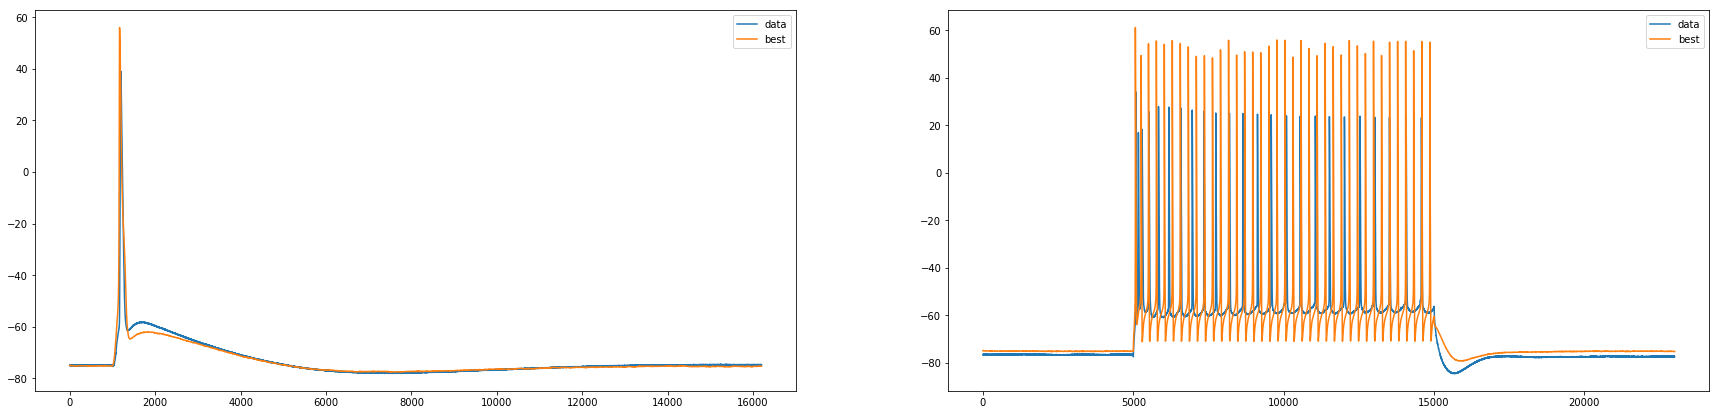

In [9]:
fig, ax  = plt.subplots(ncols=2, figsize=(30,7))
ax[0].plot(vr, label='data')
ax[0].plot(U, label='best')
ax[0].legend();

ax[1].plot(vs, label='data')
ax[1].plot(U_step, label='best');
ax[1].legend();

## Calculate The Features

In [10]:
data_feat_ramp = calc_features_ramp(vr, tr, dtr, t_onr, t_offr)
data_feat_ramp

array([-74.9345 , 113.997  ,   0.73   , -59.96875,  14.21575,  19.73   ,
        -0.75   ,   1.39   , -78.09375])

In [11]:
data_feat_step = calc_features_step(vs, ts, dts, t_ons, t_offs)
data_feat_step

array([-76.63358125, 0.06351057982730121, 48.0, 20.62173913043478,
       6.066798921122928, 24,
       array([254.6 , 258.4 , 264.6 , 275.95, 291.85, 309.  , 328.9 , 347.95,
       367.45, 387.1 , 409.75, 432.15, 456.4 , 479.25, 504.55, 527.35,
       552.55, 575.95, 600.95, 626.85, 651.45, 675.85, 703.5 , 728.9 ])],
      dtype=object)

## Create Comparison DF

#### Ramp Current

In [12]:
df_diff_ramps = df_ramps.copy() - data_feat_ramp
df_diff_ramps['sum'] = df_diff_ramps.sum(axis=1)
df_diff_ramps['sum'] = np.abs(df_diff_ramps['sum'])

df_diff_ramps.index.rename('id', inplace=True)
df_diff_ramps.reset_index(level=0, inplace=True)


#### Step Current

In [13]:
df_diff_steps = df_steps.dropna()
df_diff_steps.drop('spike_times_stim', axis=1, inplace=True)
df_diff_steps = df_diff_steps - data_feat_step[:-1]

df_diff_steps.index.rename('id', inplace=True)
df_diff_steps.reset_index(level=0, inplace=True)
df_diff_steps['sum'] = df_diff_steps.drop('spike_count', axis=1).sum(axis=1)


/home/alteska/anaconda3/envs/dap2/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### Pick The Best For Both Currents

In [22]:
n = 2
df_best_ramps = df_diff_ramps.sort_values('sum').head(n)
df_best_steps = df_diff_steps.sort_values('spike_count').head(n)

## Merge With DFTraces to Get the best Traces and Parameters

In [23]:
names=['id','gbar_nap','gbar_leak','gbar_nat','gbar_kdr','gbar_hcn','ramp_traces', 'step_traces']

In [24]:
df_best_ramp_tr = pd.merge(df_traces, df_best_ramps)[names]
df_best_ramp_tr.head(3)

,id,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,gbar_hcn,ramp_traces,step_traces
0,1x39,15.451121,1.068316,165.590385,3.516230,0.054795,"[-75.00190707130862, -74.99991605178914, -75.0...","[-75.01721176780092, -75.00840410830051, -75.0..."
1,1x23,14.846420,1.036250,162.569796,3.388068,0.050267,"[-74.98687013992779, -75.03204115686982, -75.0...","[-75.00450141301815, -75.02216024535687, -75.0..."


In [25]:
df_best_step_tr = pd.merge(df_traces, df_best_steps)[names]
df_best_step_tr.head(3)

,id,gbar_nap,gbar_leak,gbar_nat,gbar_kdr,gbar_hcn,ramp_traces,step_traces
0,1x37,14.442994,1.032129,169.273078,3.453050,0.051531,"[-74.9996134547085, -75.02300656531001, -75.02...","[-74.99682441390374, -75.05395442336598, -75.0..."
1,1x27,11.542190,1.070013,172.120981,2.862942,0.053684,"[-74.99745948984253, -75.02789366046399, -75.0...","[-74.99378068898605, -75.08514870322432, -75.2..."


## Visualize Best Results of Given Batch

### Ramp Current

In [26]:
traces_ramp = df_best_ramp_tr.ramp_traces
traces_step = df_best_ramp_tr.step_traces
ids = df_best_ramp_tr.id

In [30]:
fig, ax = plt.subplots(ncols=2, figsize=(30, 7))

ax[0].plot(vr, c='r', label='data');
ax[0].plot(U, c='r', label='data');

ax[1].plot(vs, c='r--', label='data');
ax[1].plot(U_step, c='r--', label='data');

for i, tr in enumerate(traces_ramp): 
    n = ids[i]
    ax[0].plot(tr, alpha=0.7, label=n)

for i, tr in enumerate(traces_step): 
    n = ids[i]
    ax[1].plot(tr, alpha=0.7, label=n)
    
ax[0].legend()
ax[1].legend();



Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fc12cb92ae8> (for post_execute):


ValueError: Invalid RGBA argument: '-r'

ValueError: Invalid RGBA argument: '-r'

<Figure size 2160x504 with 2 Axes>

### Step Current

In [28]:
traces_ramp = df_best_step_tr.ramp_traces
traces_step = df_best_step_tr.step_traces
ids = df_best_step_tr.id

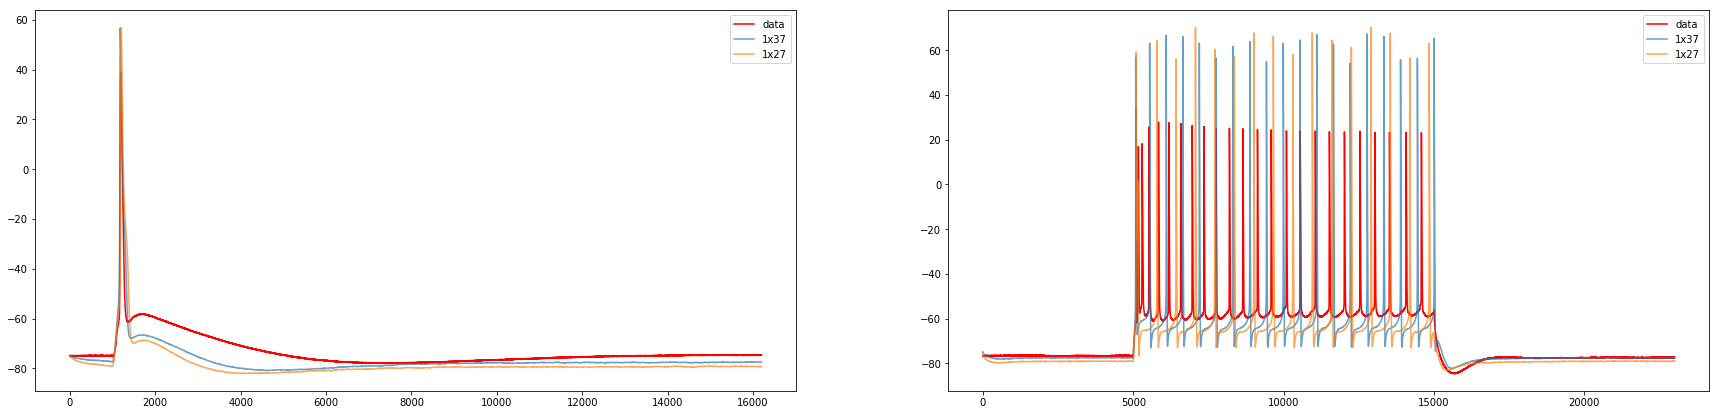

In [29]:
fig, ax = plt.subplots(ncols=2, figsize=(30, 7))

ax[0].plot(vr, c='r', label='data');
ax[1].plot(vs, c='r', label='data');

for i, tr in enumerate(traces_ramp): 
    n = ids[i]
    ax[0].plot(tr, alpha=0.7, label=n)

for i, tr in enumerate(traces_step): 
    n = ids[i]
    ax[1].plot(tr, alpha=0.7, label=n)
    
ax[0].legend()
ax[1].legend();

